In [1]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler

In [17]:
dfstocks = pd.read_csv('../../data/S&Pfinancedata.csv',parse_dates = True)
dftweets = pd.read_csv('../../data/sandp500processedVADER.csv', parse_dates = True)

In [18]:
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['date'] = pd.to_datetime(dftweets['date'])
dftweets = dftweets.groupby(['date'], as_index = False ).mean().sort_values('compound', ascending= True).reset_index()
dftweets.sort_values('date', inplace=True, ascending=True)
merged = pd.merge(left=dftweets, left_on='date',
         right=dfstocks, right_on='Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
#merged = merged[1:]

for i in range(merged.shape[0]):
    if merged['Difference'].iloc[i] >= 0:
        merged['Difference'].iloc[i] = 1
    else:
        merged['Difference'].iloc[i] = 0
merged.head()

,index,date,Unnamed: 0,Unnamed: 0.1,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,...,neutral,compound,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,0,2018-06-01,84226.0,156854.766497,1.002536e+18,0.081218,0.299492,0.984772,0.030457,1.001415e+18,...,0.881005,0.041797,2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,2734.620117,3684130000,1.0
1,3,2018-06-04,83815.0,156137.213483,1.003659e+18,0.213483,0.475655,1.936330,0.086142,1.003303e+18,...,0.846801,0.145254,2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,2746.870117,3376510000,1.0
2,4,2018-06-05,83515.5,155581.213855,1.003993e+18,0.168675,0.403614,2.147590,0.054217,1.003537e+18,...,0.858431,0.170254,2018-06-05,2748.459961,2752.610107,2739.510010,2748.800049,2748.800049,3517790000,1.0
3,5,2018-06-06,83227.5,155066.151639,1.004359e+18,0.110656,0.290984,0.831967,0.020492,1.003947e+18,...,0.845963,0.124826,2018-06-06,2753.250000,2772.389893,2748.459961,2772.350098,2772.350098,3651640000,1.0
4,6,2018-06-07,82997.0,154606.746544,1.004709e+18,0.110599,0.253456,0.797235,0.023041,1.004683e+18,...,0.862788,0.071476,2018-06-07,2774.840088,2779.899902,2760.159912,2770.370117,2770.370117,3711330000,0.0


In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

'''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    return np.array(dataX), np.array(dataY)
'''


'\ndef create_dataset(dataset, look_back=1):\n    dataX, dataY = [], []\n    for i in range(len(dataset) - look_back - 1):\n        a = dataset[i:(i + look_back), :]\n        dataX.append(a)\n        dataY.append(dataset[i + look_back, 1])\n    return np.array(dataX), np.array(dataY)\n'

In [20]:
n_days = 2
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[14, 15, 16, 17, 18, 19]


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
2,0.603486,0.600581,0.627764,0.644864,0.341171,0.323692,0.644864,0.642470,0.623071,0.664608,0.665462,0.289534,0.812187,0.665462,0.668707
3,0.642470,0.623071,0.664608,0.665462,0.289534,0.812187,0.665462,0.653994,0.629416,0.662871,0.668707,0.313249,0.930231,0.668707,0.708305
4,0.653994,0.629416,0.662871,0.668707,0.313249,0.930231,0.668707,0.662124,0.665790,0.677969,0.708305,0.335717,0.715732,0.708305,0.704975
5,0.662124,0.665790,0.677969,0.708305,0.335717,0.715732,0.708305,0.698766,0.679600,0.697707,0.704975,0.345737,0.463829,0.704975,0.719537
6,0.698766,0.679600,0.697707,0.704975,0.345737,0.463829,0.704975,0.683492,0.678663,0.703494,0.719537,0.247015,0.671708,0.719537,0.724530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.836612,0.836959,0.851140,0.849411,0.258648,0.286275,0.849411,0.803754,0.784053,0.774179,0.792191,0.376061,0.450110,0.792191,0.798615
247,0.803754,0.784053,0.774179,0.792191,0.376061,0.450110,0.792191,0.796473,0.792623,0.798977,0.798615,0.207431,0.447168,0.798615,0.758815
248,0.796473,0.792623,0.798977,0.798615,0.207431,0.447168,0.798615,0.792434,0.791059,0.767582,0.758815,0.414573,0.503300,0.758815,0.726246
249,0.792434,0.791059,0.767582,0.758815,0.414573,0.503300,0.758815,0.724920,0.701907,0.707661,0.726246,0.343844,0.271933,0.726246,0.736065


In [21]:
train_size = int(merged.shape[0]*0.67)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-n_features]
test_X, test_y = test[:,:n_obs], test[:,-n_features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [22]:
batch_size = 32
epochs = 50
np.random.seed(420)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 168 samples, validate on 81 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
168/168 [==============================] - 1s 8ms/sample - loss: 0.3170 - acc: 0.0060 - val_loss: 0.1710 - val_acc: 0.0000e+00
Epoch 2/50
168/168 [==============================] - 0s 821us/sample - loss: 0.0752 - acc: 0.0060 - val_loss: 0.0051 - val_acc: 0.0123
Epoch 3/50
168/168 [==============================] - 0s 702us/sample - loss: 0.0658 - acc: 0.0060 - val_loss: 0.0025 - val_acc: 0.0123
Epoch 4/50
168/168 [==============================] - 0s 1ms/sample - loss: 0.0337 - acc: 0.0060 - val_loss: 0.0412 - val_acc: 0.0123
Epoch 5/50
168/168 [==============================] - 0s 1ms/sample - loss: 0.0358 - acc: 0.0060 - val_loss: 0.0495 - val_acc: 0.0123
Epoch 6/50
168/168 [==============================] - 0s 708us/sa

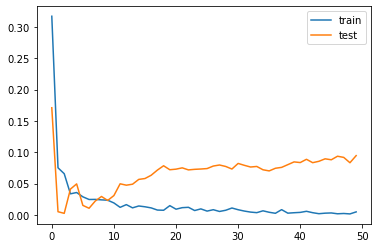

In [23]:
model = Sequential()
model.add(LSTM(128, dropout=0.4, recurrent_dropout = 0.4,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(96, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense (Dense)                (None, 96)                12384     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1552      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 83,585
Trainable params: 83,585
Non-trainable params: 0
_________________________________________________________________


In [25]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,6]

In [26]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [27]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)

10.808785


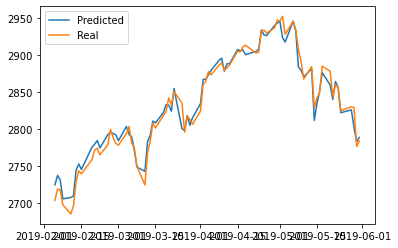

In [28]:
x = merged['Date'][train_size+2:]
plt.plot(x,inv_yhat, label = "Predicted")
plt.plot(x,inv_y, label = "Real")
#plt.plot(x, merged['Close'][train_size:len(merged)-2], label = "Close")
plt.legend()